# Getting started

## Installation

To install `cosmologix`, you need Python 3.10 or newer. Use pip:

```sh
pip install cosmologix
```

Note: Make sure you have JAX installed, along with its dependencies. If you're using GPU acceleration, ensure CUDA and cuDNN are properly set up.

## Command line interface

For most common use cases, there is a simple command line interface to the library. You can perform fit, contour exploration and contour plotting as follows:

In [1]:
! cosmologix fit --priors PR4 --priors DESIDR2 --cosmology FwCDM -s
! cosmologix explore Omega_bc w --priors PR4 --priors DESIDR2 --cosmology FwCDM -o contours.pkl
! cosmologix contour contours.pkl -s -o contour.png

Omega_bc = 0.2949 ± 0.0076
H0 = 68.99 ± 0.98
Omega_b_h2 = 0.02236 ± 0.00013
w = -1.027 ± 0.041
χ²=14.34 (d.o.f. = 12), χ²/d.o.f = 1.195
p-value: 27.94%
Figure(1000x1000)
Exploring contour ['Omega_bc', 'w'] (upper bound estimate):   2%| | 30/1566 [00:
Contour data saved to contours.pkl
Contour plot saved to contour.png
Figure(640x480)


## High level interface

All commands available from the command line have their equivalent accessible in python as follows:

Omega_bc = 0.2949 ± 0.0076
H0 = 68.99 ± 0.98
Omega_b_h2 = 0.02236 ± 0.00013
w = -1.027 ± 0.041
χ²=14.34 (d.o.f. = 12), χ²/d.o.f = 1.195
p-value: 27.94%


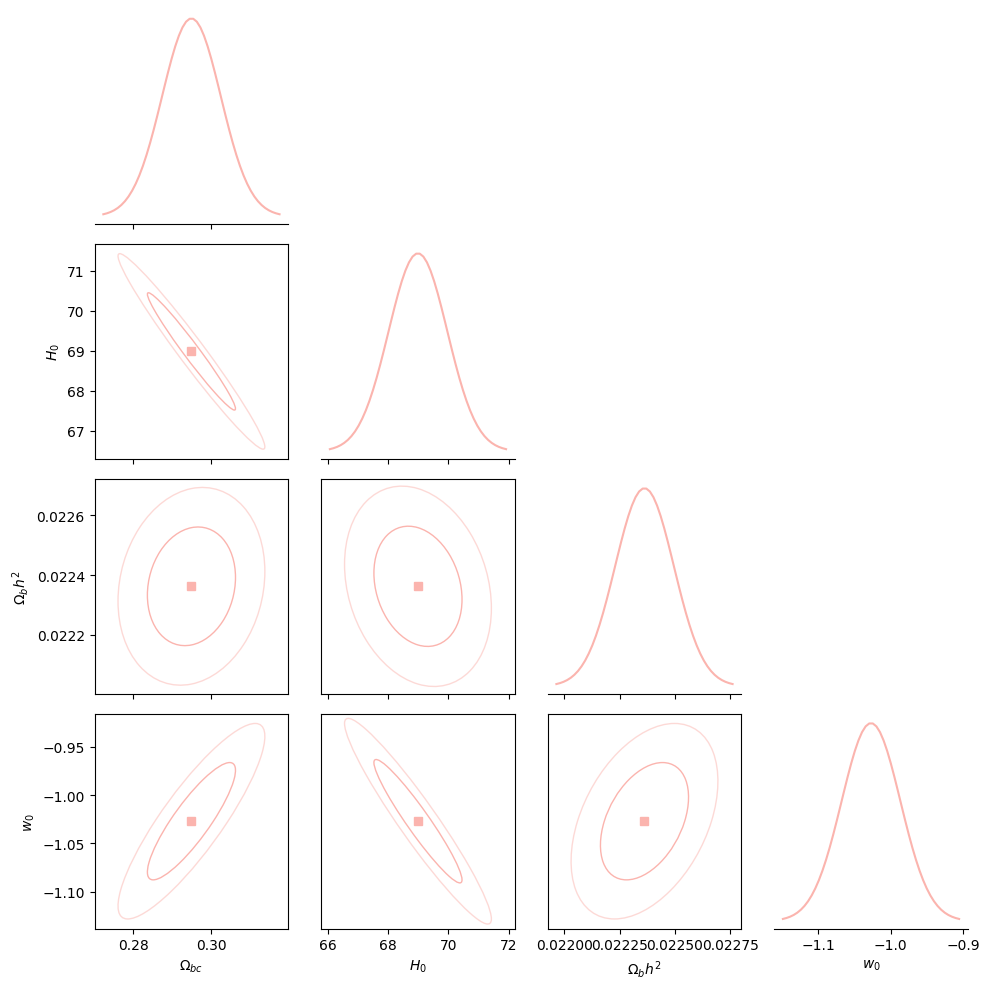

In [2]:
from cosmologix import cli
bestfit = cli.fit(prior_names=['PR4', 'DESIDR2'], cosmology='FwCDM', show=True)

Exploring contour (upper bound estimate): 17it [00:04,  4.02it/s]                                                                                                                                                  
Exploring contour ['Omega_bc', 'H0'] (upper bound estimate):   3%|██▊                                                                                                            | 91/3556 [00:04<02:56, 19.62it/s]
Exploring contour ['Omega_bc', 'w'] (upper bound estimate):   2%|██▌                                                                                                             | 98/4387 [00:02<01:30, 47.25it/s]
Exploring contour (upper bound estimate): 30it [00:03,  8.46it/s]                                                                                                                                                  
Exploring contour ['H0', 'w'] (upper bound estimate):   4%|████▎                                                                                        

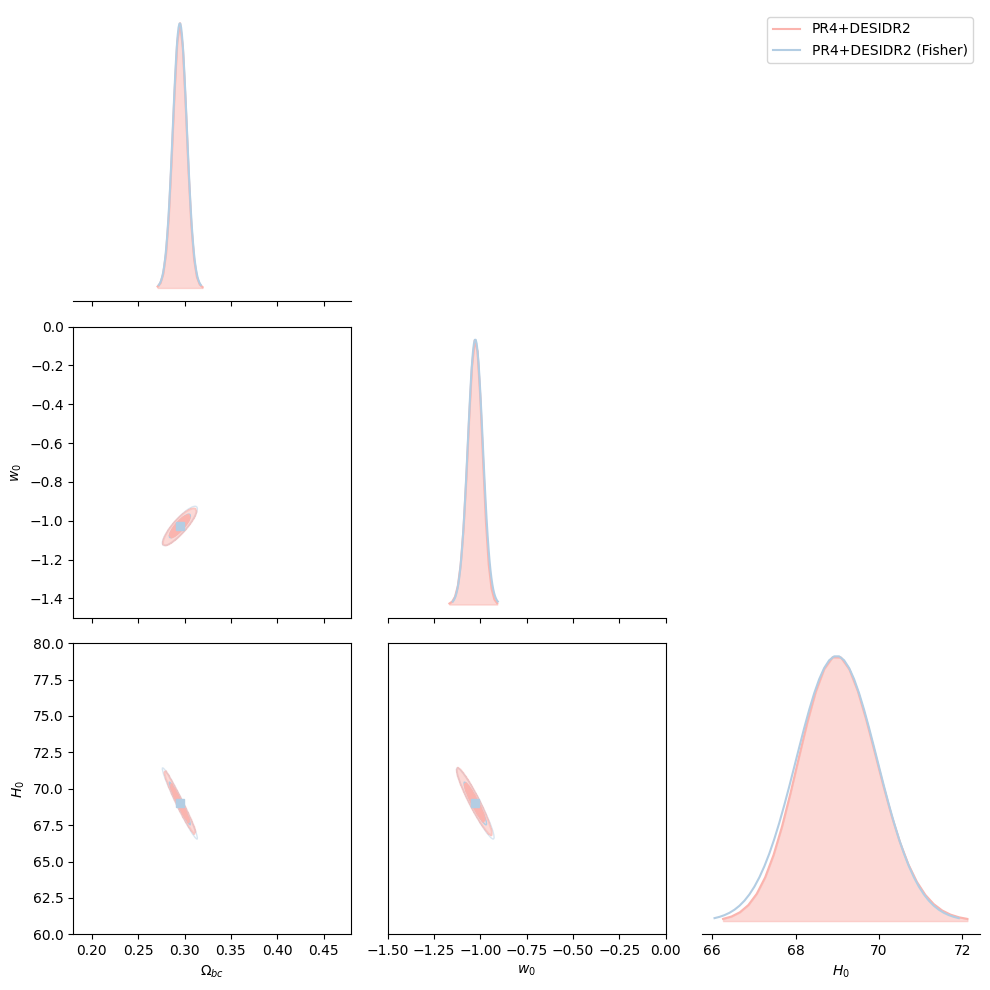

In [3]:
results = cli.explore(['Omega_bc', 'H0', 'w'], prior_names=['PR4', 'DESIDR2'], resolution=100)
cli.corner([results, bestfit])


## Supernovae data

The code provides shortcuts to download the last 4 commonly-used compilation of supernovae distance modulus measurements. The shortcuts and the corresponding references are:
- JLA [Betoule et al. 2014](https://arxiv.org/abs/1401.4064)
- Pantheonplus [Scolnic et al. 2022](https://arxiv.org/abs/2112.03863)
- Union3 [Rubin et al. 2025](https://arxiv.org/abs/2311.12098)
- DES5yr [DES collaboration, 2024](https://arxiv.org/abs/2401.02929)

Using any of those will trigger the download and caching of the relevant data at first try which requires an internet connexion.

In [4]:
lcdm_sn_bestfit = cli.fit(prior_names=['Union3'], cosmology='LCDM', fix=[('H0', 70), ('Omega_b_h2', 0.02222)])

File downloaded and cached at: /home/betoule/.cache/cosmologix/a87b9221eb4fda9cc6babb291caf6267
Omega_bc = 0.286 ± 0.065
Omega_k = 0.20 ± 0.18
M = -0.060 ± 0.089
χ²=22.56 (d.o.f. = 19), χ²/d.o.f = 1.187
p-value: 25.75%


### Distance measurements

One can also provide custom distance modulus measurements as numpy record arrays. The measurements can be provided as a single 3 column record array (or file) with redshift, distance modulus, and 1-sigma uncertainty in the distance modulus. In this case, measurements are assumed uncorrelated:

In [5]:
import numpy as np
mu = np.rec.fromarrays([
    [0.01, 0.03, 0.1,  0.3, 1],
    [33.25826259, 35.67605115, 38.39599686, 41.03170593, 44.1646754],
    [0.01, 0.01, 0.01, 0.01, 0.01]
    ], names=['z', 'mu', 'muerr'])
fit = cli.fit(prior_names=[], cosmology='LCDM', fix=[('H0', 70), ('Omega_b_h2', 0.02222)], mu=mu)

Omega_bc = 0.313 ± 0.042
Omega_k = -0.00 ± 0.12
M = 0.0832 ± 0.0074
χ²=0.00 (d.o.f. = 2), χ²/d.o.f = 0.000
p-value: 100.00%


Alternatively, one can also provide the covariance matrix of the mu vector. Note that in this case the `muerr` column is ignored if provided.

In [6]:
fit = cli.fit(prior_names=[], cosmology='LCDM', fix=[('H0', 70), ('Omega_b_h2', 0.02222)], mu=mu, mucov=np.diag(np.full(5, 0.005**2)))

Omega_bc = 0.313 ± 0.021
Omega_k = -0.000 ± 0.062
M = 0.0832 ± 0.0037
χ²=0.00 (d.o.f. = 2), χ²/d.o.f = 0.000
p-value: 100.00%


## Low level interface
If you need more control on the plots or more basic tasks, you can use directly the core library. Here's a quick example to get you started (look at
[example/features.py](https://gitlab.in2p3.fr/lemaitre/cosmologix/-/blob/master/examples/features.py)
for a more complete tour of the available features):

In [7]:
from cosmologix import distances, parameters
import jax.numpy as jnp

In [8]:
# Best-fit parameters to Planck 2018 are:
print(parameters.Planck18)

{'Tcmb': 2.7255, 'Omega_bc': 0.31315017687047186, 'H0': 67.37, 'Omega_b_h2': 0.02233, 'Omega_k': 0.0, 'w': -1.0, 'wa': 0.0, 'm_nu': 0.06, 'Neff': 3.046}


In [9]:
# Redshift values for supernovae
z_values = jnp.linspace(0.1, 1.0, 10)

# Compute distance modulus 
distance_modulus = distances.mu(parameters.Planck18, z_values)
print(distance_modulus)

[38.39599686 40.03474604 41.03170593 41.75860618 42.33336668 42.80935305
 43.21557803 43.56971025 43.88337776 44.1646754 ]


In [10]:
# Find bestfit flat w-CDM cosmology
from cosmologix import likelihoods, fitter
priors = [likelihoods.Planck2018(), likelihoods.DES5yr()]
fixed = {'Omega_k':0., 'm_nu':0.06, 'Neff':3.046, 'Tcmb': 2.7255, 'wa':0.0}

result = fitter.fit(priors, fixed=fixed, verbose=True)
print(result['bestfit'])

Using cached file: /home/betoule/.cache/cosmologix/func_cache_DES5yr
{'Omega_bc': 0.31315017687047186, 'H0': 67.37, 'Omega_b_h2': 0.02233, 'w': -1.0, 'M': 0.0}
[ 3.13150177e-01  6.73700000e+01  2.23300000e-02 -1.00000000e+00
  0.00000000e+00]
[-1.71813223e-02  1.72145410e+00 -1.50020393e-05 -5.29155124e-02
  1.13827835e-01]
[ 3.30331499e-01  6.56485459e+01  2.23450020e-02 -9.47084488e-01
 -1.13827835e-01]
[-6.73454972e-04 -4.89104362e-03  8.41230988e-07 -5.45985852e-04
  5.58152712e-04]
[ 3.31004954e-01  6.56534369e+01  2.23441608e-02 -9.46538502e-01
 -1.14385988e-01]
[-1.74727282e-06  1.36761715e-04  1.20863850e-08 -7.62367478e-06
  1.83106772e-06]
{'Omega_bc': Array(0.3310067, dtype=float64), 'H0': Array(65.65330018, dtype=float64), 'Omega_b_h2': Array(0.02234415, dtype=float64), 'w': Array(-0.94653088, dtype=float64), 'M': Array(-0.11438782, dtype=float64)}


In [11]:
#Compute frequentist confidence contours. 

from cosmologix import contours, display
grid = contours.frequentist_contour_2d_sparse(
    priors,
    grid={'Omega_bc': [0.18, 0.48, 30], 'w': [-0.6, -1.5, 30]},
    fixed=fixed
    )


Exploring contour ['Omega_bc', 'w'] (upper bound estimate):   7%|███████▉                                                                                                         | 27/382 [00:04<00:57,  6.18it/s]


The progress bar provides a rough upper bound on computation time because the actual size of the explored region is unknown at the start of the calculation.

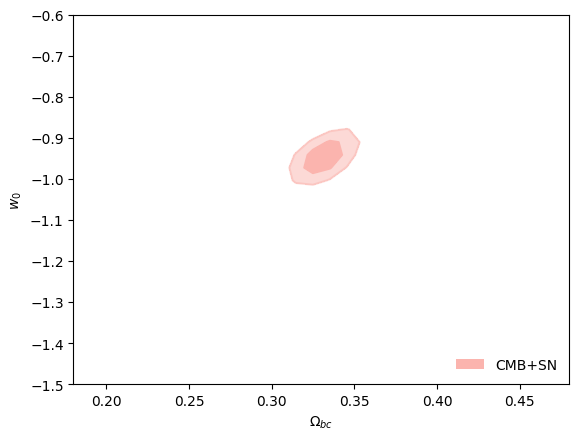

In [12]:
import matplotlib.pyplot as plt
display.plot_contours(grid, filled=True, label='CMB+SN')
plt.ion()
plt.legend(loc='lower right', frameon=False)
plt.show()

Further examples can be found reading files in the examples directory, especially [example/features.py](https://gitlab.in2p3.fr/lemaitre/cosmologix/-/blob/master/examples/features.py).